In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
# if device_name == '/device:GPU:0':
#     print('Found GPU at: {}'.format(device_name))
# else:
#     raise SystemError('GPU device not found')

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/clean_data.csv')

In [ ]:
df['toxic'] = [int(i) for i in df['toxic']]

In [ ]:
sentences = df.comment.values
labels = df.toxic.values

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  верблюд дебил бл
Tokenized:  ['в', '##е', '##р', '##б', '##л', '##ю', '##д', 'д', '##е', '##б', '##и', '##л', 'б', '##л']
Token IDs:  [1182, 15290, 16856, 29740, 29436, 29757, 29742, 1184, 15290, 29740, 10325, 29436, 1181, 29436]


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 150,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  верблюд дебил бл
Token IDs: tensor([  101,  1182, 15290, 16856, 29740, 29436, 29757, 29742,  1184, 15290,
        29740, 10325, 29436,  1181, 29436,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

12,720 training samples
1,414 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
# model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 1

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

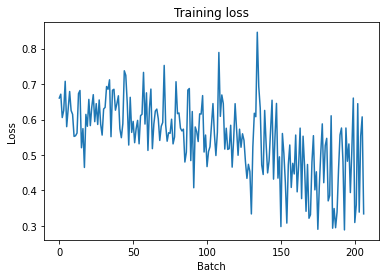

KeyboardInterrupt: ignored

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    train_loss_set = []

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        print('==============')
        # Progress update every 40 batches.
        if step % 2 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        
        train_loss_set.append(loss.item())

        clear_output(True)
        plt.plot(train_loss_set)
        plt.title("Training loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# xml-rob + rank

In [2]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 28.3 MB/s 
     |████████████████████████████████| 596 kB 61.7 MB/s 
     |████████████████████████████████| 895 kB 44.1 MB/s 
     |████████████████████████████████| 77 kB 7.9 MB/s 
     |████████████████████████████████| 6.6 MB 58.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
# Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
from collections import defaultdict
import pandas as pd
import numpy as np
import os
import re
import random
import gc
pd.set_option('display.max_columns', None)
np.seterr(divide='ignore', invalid='ignore')
gc.enable()

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
# NLP
from transformers import AutoTokenizer, AutoModel

# Random Seed Initialize
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

# Device Optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'Using device: {device}')

Using device: cuda


In [10]:
data_dir = '/content/drive/MyDrive/берта/validation_data_5_folds.csv'
# train_file_path = os.path.join(data_dir, 'validation_data_5_folds.csv')
print(f'Train file: {data_dir}')

Train file: /content/drive/MyDrive/берта/validation_data_5_folds.csv


In [11]:
train_df = pd.read_csv(data_dir)

In [12]:
def text_cleaning(text):
    '''
    Cleans text into a basic form for NLP. Operations include the following:-
    1. Remove special charecters like &, #, etc
    2. Removes extra spaces
    3. Removes embedded URL links
    4. Removes HTML tags
    5. Removes emojis
    
    text - Text piece to be cleaned.
    '''
    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)
    
    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    text = re.sub(r"[^a-zA-Z\d]", " ", text) #Remove special Charecters
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = text.strip() # remove spaces at the beginning and at the end of string

    return text

In [13]:
tqdm.pandas()
train_df['less_toxic'] = train_df['less_toxic'].progress_apply(text_cleaning)
train_df['more_toxic'] = train_df['more_toxic'].progress_apply(text_cleaning)

  0%|          | 0/30108 [00:00<?, ?it/s]

  0%|          | 0/30108 [00:00<?, ?it/s]

In [14]:
train_df.sample(10)

,worker,less_toxic,more_toxic,kfold
20578,56,of course it s nuclear any moron who has read ...,Unblock me now you piece of shit Or I will fin...,3
26465,446,Perspective In the trial Shylock represents th...,So apparently an inability to read can make yo...,4
28404,340,Oh really Well then stop making bullsht edits ...,I have corrected the section on Twin earth for...,4
19714,36,Please refrain from adding nonsense to Wikiped...,this page smells very bad,2
3752,441,Dear SchfiftyThree I would just like to say th...,TAKE YOUR JOB AS SERIOUSLY AS POSSIBLE YOU LOS...,0
20191,4,Wiki is a two way street deleting a post becau...,In actual fact Oh no not again is a four word ...,2
3518,682,Maybe we can get a vote I m flexible with my v...,Fuck off Wolfkeeper Talk,0
24602,200,Jew Marxist Raus Raus Raus,No MORON I am not admitting any of those thing...,4
13730,613,Rochester WIKI Hi Please stop putting that rid...,BITCH Your a bitch Why did you delete the Engl...,2
12554,725,I challenge you to present a shred of evidence...,How about you learn how to read and write duri...,1


In [15]:
train_df.groupby(['kfold']).size()

kfold
0    6022
1    6022
2    6022
3    6021
4    6021
dtype: int64

In [16]:
params = {
    'device': device,
    'debug': False,
    'checkpoint': 'xlm-roberta-base',
    'output_logits': 768,
    'max_len': 256,
    'num_folds': train_df['kfold'].nunique(),
    'batch_size': 4,
    'dropout': 0.2,
    'num_workers': 2,
    'epochs': 1,
    'lr': 2e-5,
    'margin': 0.7,
    'scheduler_name': 'OneCycleLR',
    'max_lr': 5e-5,                 # OneCycleLR
    'pct_start': 0.1,               # OneCycleLR
    'anneal_strategy': 'cos',       # OneCycleLR
    'div_factor': 1e3,              # OneCycleLR
    'final_div_factor': 1e3,        # OneCycleLR
    'no_decay': True
}

In [17]:
if params['debug']:
    train_df = train_df.sample(frac=0.01)
    print('Reduced training Data Size for Debugging purposes')

In [18]:
class BERTDataset:
    def __init__(self, more_toxic, less_toxic, max_len=params['max_len'], checkpoint=params['checkpoint']):
        self.more_toxic = more_toxic
        self.less_toxic = less_toxic
        self.max_len = max_len
        self.checkpoint = checkpoint
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        self.num_examples = len(self.more_toxic)

    def __len__(self):
        return self.num_examples

    def __getitem__(self, idx):
        more_toxic = str(self.more_toxic[idx])
        less_toxic = str(self.less_toxic[idx])

        tokenized_more_toxic = self.tokenizer(
            more_toxic,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_attention_mask=True,
            return_token_type_ids=True,
        )

        tokenized_less_toxic = self.tokenizer(
            less_toxic,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_attention_mask=True,
            return_token_type_ids=True,
        )

        ids_more_toxic = tokenized_more_toxic['input_ids']
        mask_more_toxic = tokenized_more_toxic['attention_mask']
        token_type_ids_more_toxic = tokenized_more_toxic['token_type_ids']

        ids_less_toxic = tokenized_less_toxic['input_ids']
        mask_less_toxic = tokenized_less_toxic['attention_mask']
        token_type_ids_less_toxic = tokenized_less_toxic['token_type_ids']

        return {'ids_more_toxic': torch.tensor(ids_more_toxic, dtype=torch.long),
                'mask_more_toxic': torch.tensor(mask_more_toxic, dtype=torch.long),
                'token_type_ids_more_toxic': torch.tensor(token_type_ids_more_toxic, dtype=torch.long),
                'ids_less_toxic': torch.tensor(ids_less_toxic, dtype=torch.long),
                'mask_less_toxic': torch.tensor(mask_less_toxic, dtype=torch.long),
                'token_type_ids_less_toxic': torch.tensor(token_type_ids_less_toxic, dtype=torch.long),
                'target': torch.tensor(1, dtype=torch.float)}

In [19]:
def get_scheduler(optimizer, scheduler_params=params):
    if scheduler_params['scheduler_name'] == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=scheduler_params['T_0'],
            eta_min=scheduler_params['min_lr'],
            last_epoch=-1
        )
    elif scheduler_params['scheduler_name'] == 'OneCycleLR':
        scheduler = OneCycleLR(
            optimizer,
            max_lr=scheduler_params['max_lr'],
            steps_per_epoch=int(df_train.shape[0] / params['batch_size']) + 1,
            epochs=scheduler_params['epochs'],
            pct_start=scheduler_params['pct_start'],
            anneal_strategy=scheduler_params['anneal_strategy'],
            div_factor=scheduler_params['div_factor'],
            final_div_factor=scheduler_params['final_div_factor'],
        )
    return scheduler

In [20]:
class MetricMonitor:
    def __init__(self, float_precision=4):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [21]:
class ToxicityModel(nn.Module):
    def __init__(self, checkpoint=params['checkpoint'], params=params):
        super(ToxicityModel, self).__init__()
        self.checkpoint = checkpoint
        self.bert = AutoModel.from_pretrained(checkpoint, return_dict=False)
        self.layer_norm = nn.LayerNorm(params['output_logits'])
        self.dropout = nn.Dropout(params['dropout'])
        self.dense = nn.Sequential(
            nn.Linear(params['output_logits'], 128),
            nn.SiLU(),
            nn.Dropout(params['dropout']),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, token_type_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = self.layer_norm(pooled_output)
        pooled_output = self.dropout(pooled_output)
        preds = self.dense(pooled_output)
        return preds

In [22]:
def train_fn(train_loader, model, criterion, optimizer, epoch, params, scheduler=None):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    
    for i, batch in enumerate(stream, start=1):
        ids_more_toxic = batch['ids_more_toxic'].to(device)
        mask_more_toxic = batch['mask_more_toxic'].to(device)
        token_type_ids_more_toxic = batch['token_type_ids_more_toxic'].to(device)
        ids_less_toxic = batch['ids_less_toxic'].to(device)
        mask_less_toxic = batch['mask_less_toxic'].to(device)
        token_type_ids_less_toxic = batch['token_type_ids_less_toxic'].to(device)
        target = batch['target'].to(device)

        logits_more_toxic = model(ids_more_toxic, token_type_ids_more_toxic, mask_more_toxic)
        logits_less_toxic = model(ids_less_toxic, token_type_ids_less_toxic, mask_less_toxic)
        loss = criterion(logits_more_toxic, logits_less_toxic, target)
        metric_monitor.update('Loss', loss.item())
        loss.backward()
        optimizer.step()
            
        if scheduler is not None:
            scheduler.step()
        
        optimizer.zero_grad()
        stream.set_description(f"Epoch: {epoch:02}. Train. {metric_monitor}")

In [23]:
def validate_fn(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    all_loss = []
    with torch.no_grad():
        for i, batch in enumerate(stream, start=1):
            ids_more_toxic = batch['ids_more_toxic'].to(device)
            mask_more_toxic = batch['mask_more_toxic'].to(device)
            token_type_ids_more_toxic = batch['token_type_ids_more_toxic'].to(device)
            ids_less_toxic = batch['ids_less_toxic'].to(device)
            mask_less_toxic = batch['mask_less_toxic'].to(device)
            token_type_ids_less_toxic = batch['token_type_ids_less_toxic'].to(device)
            target = batch['target'].to(device)

            logits_more_toxic = model(ids_more_toxic, token_type_ids_more_toxic, mask_more_toxic)
            logits_less_toxic = model(ids_less_toxic, token_type_ids_less_toxic, mask_less_toxic)
            loss = criterion(logits_more_toxic, logits_less_toxic, target)
            all_loss.append(loss.item())
            metric_monitor.update('Loss', loss.item())
            stream.set_description(f"Epoch: {epoch:02}. Valid. {metric_monitor}")
            
    return np.mean(all_loss)

In [24]:
best_models_of_each_fold = []

In [18]:
gc.collect()
for fold in range(params['num_folds']):
    print(f'******************** Training Fold: {fold+1} ********************')
    current_fold = fold
    df_train = train_df[train_df['kfold'] != current_fold].copy()
    df_valid = train_df[train_df['kfold'] == current_fold].copy()

    train_dataset = BERTDataset(
        df_train.more_toxic.values,
        df_train.less_toxic.values
    )
    valid_dataset = BERTDataset(
        df_valid.more_toxic.values,
        df_valid.less_toxic.values
    )

    train_dataloader = DataLoader(
        train_dataset, batch_size=params['batch_size'], shuffle=True,
        num_workers=params['num_workers'], pin_memory=True
    )
    valid_dataloader = DataLoader(
        valid_dataset, batch_size=params['batch_size']*2, shuffle=False,
        num_workers=params['num_workers'], pin_memory=True
    )
    
    model = ToxicityModel()
    model = model.to(params['device'])
    criterion = nn.MarginRankingLoss(margin=params['margin'])
    if params['no_decay']:
        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = optim.AdamW(optimizer_grouped_parameters, lr=params['lr'])
    else:
        optimizer = optim.AdamW(model.parameters(), lr=params['lr'])
    scheduler = get_scheduler(optimizer)

    # Training and Validation Loop
    best_loss = np.inf
    best_epoch = 0
    best_model_name = None
    for epoch in range(1, params['epochs'] + 1):
        train_fn(train_dataloader, model, criterion, optimizer, epoch, params, scheduler)
        valid_loss = validate_fn(valid_dataloader, model, criterion, epoch, params)
        if valid_loss <= best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            if best_model_name is not None:
                os.remove(best_model_name)
            torch.save(model.state_dict(), f"{params['checkpoint']}_{epoch}_epoch_f{fold+1}.pth")
            best_model_name = f"{params['checkpoint']}_{epoch}_epoch_f{fold+1}.pth"

    # Print summary of this fold
    print('')
    print(f'The best LOSS: {best_loss} for fold {fold+1} was achieved on epoch: {best_epoch}.')
    print(f'The Best saved model is: {best_model_name}')
    best_models_of_each_fold.append(best_model_name)
    del df_train, df_valid, train_dataset, valid_dataset, train_dataloader, valid_dataloader, model
    _ = gc.collect()
    torch.cuda.empty_cache()

******************** Training Fold: 1 ********************


Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/6022 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]


The best LOSS: 0.6999989574648945 for fold 1 was achieved on epoch: 1.
The Best saved model is: xlm-roberta-base_1_epoch_f1.pth
******************** Training Fold: 2 ********************


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/6022 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]


The best LOSS: 0.6999964377636295 for fold 2 was achieved on epoch: 1.
The Best saved model is: xlm-roberta-base_1_epoch_f2.pth
******************** Training Fold: 3 ********************


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/6022 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]


The best LOSS: 0.6999314769330728 for fold 3 was achieved on epoch: 1.
The Best saved model is: xlm-roberta-base_1_epoch_f3.pth
******************** Training Fold: 4 ********************


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/6022 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]


The best LOSS: 0.6999924257298706 for fold 4 was achieved on epoch: 1.
The Best saved model is: xlm-roberta-base_1_epoch_f4.pth
******************** Training Fold: 5 ********************


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/6022 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]


The best LOSS: 0.7000001499535712 for fold 5 was achieved on epoch: 1.
The Best saved model is: xlm-roberta-base_1_epoch_f5.pth


In [33]:
params_t = {
    'device': device,
    'debug': False,
    'checkpoint': '../input/roberta-base',
    'output_logits': 768,
    'max_len': 256,
    'batch_size': 32,
    'dropout': 0.2,
    'num_workers': 2
}

In [34]:
if params['debug']:
    train_df = train_df.sample(frac=0.01)
    print('Reduced training Data Size for Debugging purposes')

In [35]:
class BERTDataset_t:
    def __init__(self, text, max_len=params['max_len'], checkpoint=params['checkpoint']):
        self.text = text
        self.max_len = max_len
        self.checkpoint = checkpoint
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        self.num_examples = len(self.text)

    def __len__(self):
        return self.num_examples

    def __getitem__(self, idx):
        text = str(self.text[idx])

        tokenized_text = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_attention_mask=True,
            return_token_type_ids=True,
        )

        ids = tokenized_text['input_ids']
        mask = tokenized_text['attention_mask']
        token_type_ids = tokenized_text['token_type_ids']

        return {'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)}

In [1]:
mod_path = '/content/drive/MyDrive/берта/xlm-roberta-base_1_epoch_f5.pth'

In [25]:
model = ToxicityModel()

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
model.load_state_dict(torch.load(mod_path))

<All keys matched successfully>

In [31]:
test_com = pd.read_csv('/content/drive/MyDrive/test_com.csv')
test_com.head()

,comment,toxic
0,че мямлить утырок сопля подтереть,1.0
1,знать это чудак буква счёт деньга сразу пойти,1.0
2,полный дестрой достаточно енот зеркалирование,0.0
3,родитель частый мать неполный семья который им...,0.0
4,рубль односкоростной рига газуля стоить солидн...,0.0


In [ ]:
model.eval()

In [37]:
test_dataset = BERTDataset_t(text = test_com['comment'].values)

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [38]:
test_loader = DataLoader(
    test_dataset, batch_size=params['batch_size'],
    shuffle=False, num_workers=params['num_workers'],
    pin_memory=True
)

In [40]:
model = model.to(params['device'])

In [41]:
predictions_nn = []
with torch.no_grad():
        for batch in tqdm(test_loader, desc=f'Predicting. '):
            ids= batch['ids'].to(device)
            mask = batch['mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            predictions = model(ids, token_type_ids, mask).to('cpu').numpy()
            predictions_nn.append(predictions)

Predicting. :   0%|          | 0/1061 [00:00<?, ?it/s]

In [43]:
predict_lab = np.concatenate(predictions_nn)

In [45]:
fin_df = pd.DataFrame()
fin_df['comment_id'] = test_com['comment']
fin_df['score'] = predict_lab
fin_df['score'] = fin_df['score'].rank(method='first')

In [48]:
fin_df[10:15]

,comment_id,score
10,блядь крутить человек херовый нормальный котор...,3746.0
11,знать вроде фильм закончить хотя короткий мале...,2992.0
12,ввс наш пока,1746.0
13,сделать дикарь общественный бытие который слож...,2941.0
14,прекрасно помнить анонсировать появление прогр...,2332.0
